# SHAP

In [1]:
import numpy as np # Use version 1.x not 2.x
import random
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
feature_names = ["actq",
    "ancq", 
    "atq",
    "cheq",
    "cogsq",
    "invtq",
    "lctq",
    "lltq",
    "ltq",
    "niq",
    "ppentq",
    "revtq",
    "teqq",
    "xsgaq",
    "GrossProfitRatio",
    "NetProfitRatio",
    "CurrentRatio",
    "QuickAcidRatio",
    "CashRatio",
    "EquityMultiplier",
    "ReturnOnAsset",
    "ReturnOnEquity",
    "InventoryTurnover"
]

In [3]:
import pickle

def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    records = []
    for company, periods in data.items():
        for period, (features, rating) in periods.items():
            record = {
                'company': company,
                'period': period,
                **{f'{feature_names[i]}': feature.item() for i, feature in enumerate(features)},
                'rating': int(rating.item())
            }
            records.append(record)

    return pd.DataFrame(records)

In [4]:
def plot_grouped_bar_chart(results_df, graph_title='Accuracy at Different Error Thresholds for Various Models'):
    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.15
    x = np.arange(len(results_df['model']))

    for i, threshold in enumerate(['accuracy_0', 'accuracy_1', 'accuracy_2', 'accuracy_3', 'accuracy_4']):
        ax.bar(x + i * width, results_df[threshold], width, label=f'Error <= {i}')

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(graph_title)
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(results_df['model'])
    ax.legend(title='Error Threshold', loc='upper left', fontsize='small')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Time Window Size = 1

In [5]:
from sklearn.preprocessing import StandardScaler

train_df = load_data('./data/train_dict.pkl')
test_df = load_data('./data/test_dict.pkl')

X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression Models

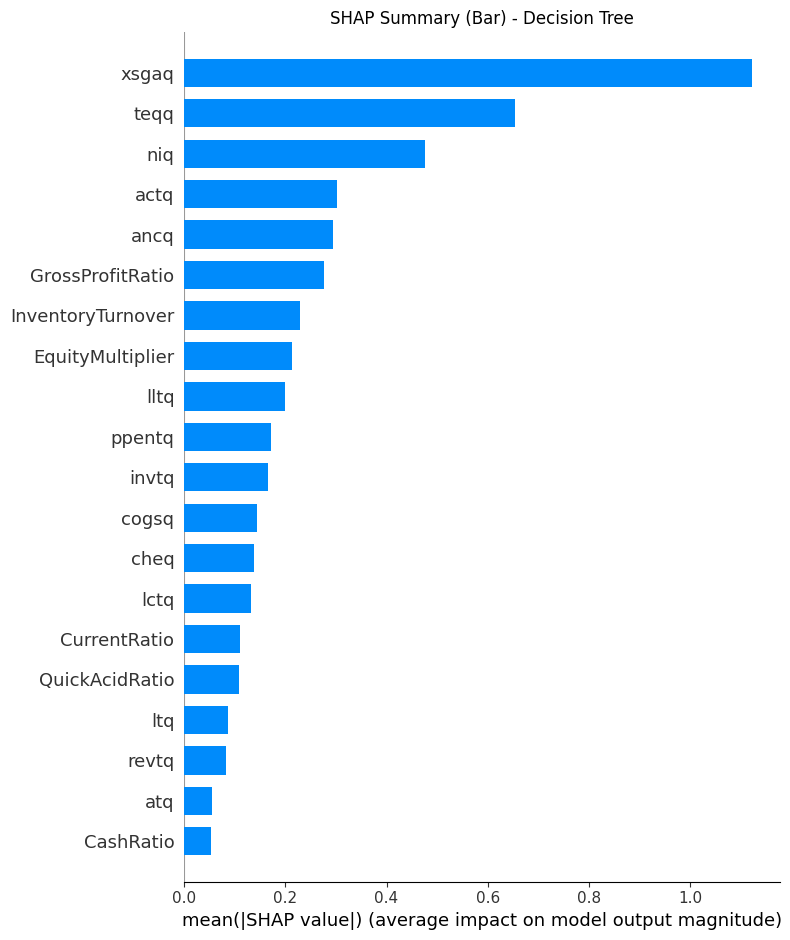

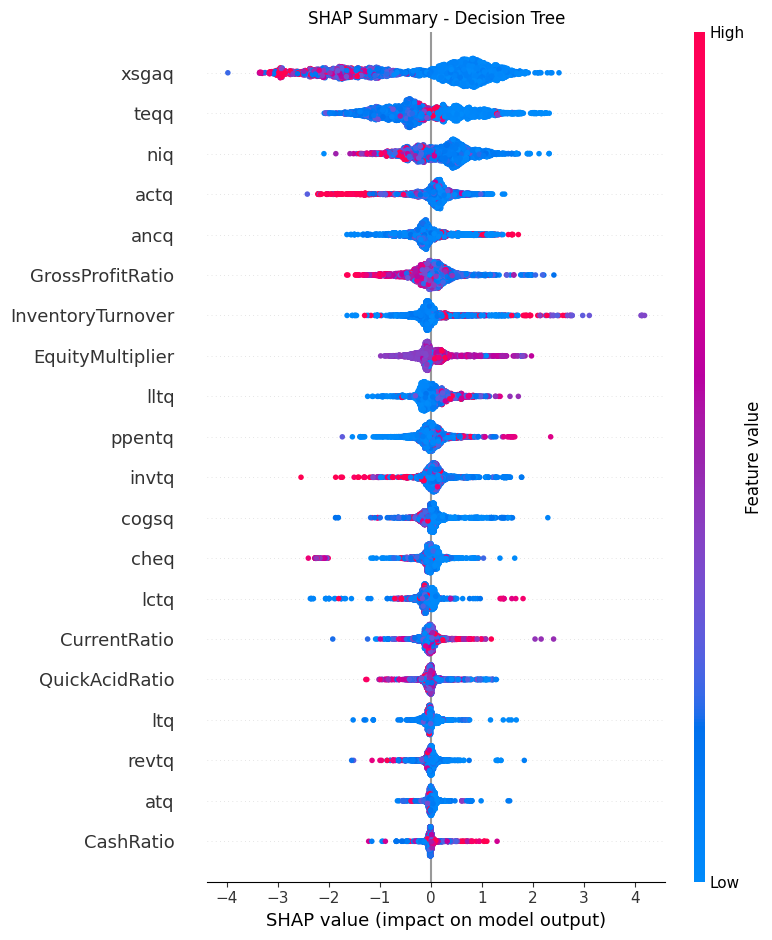

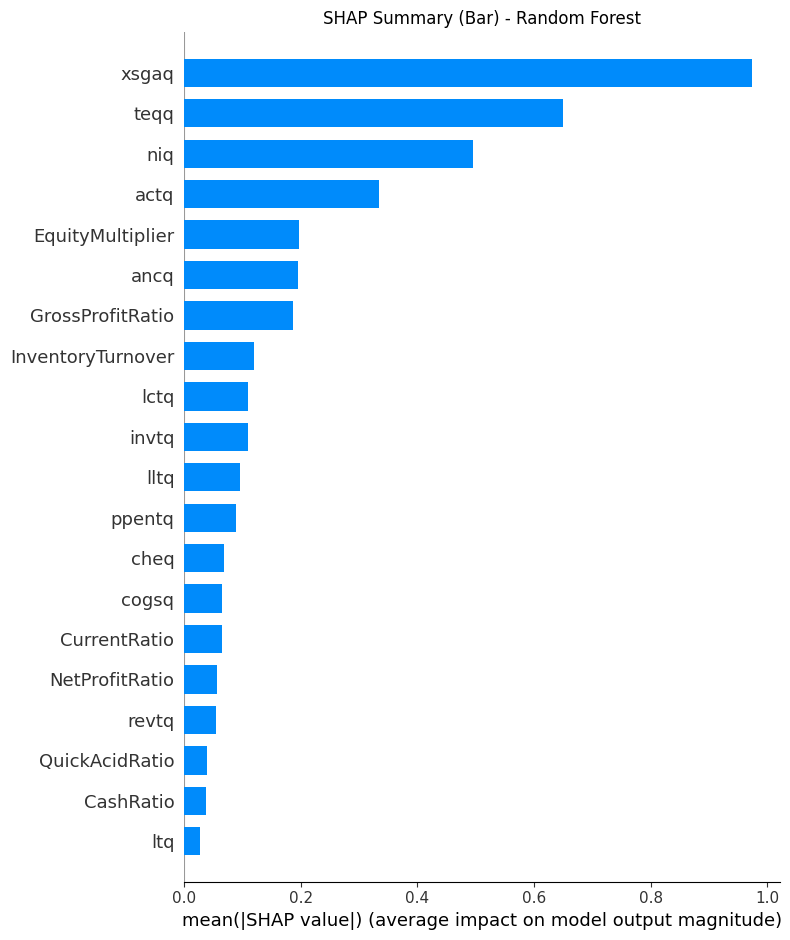

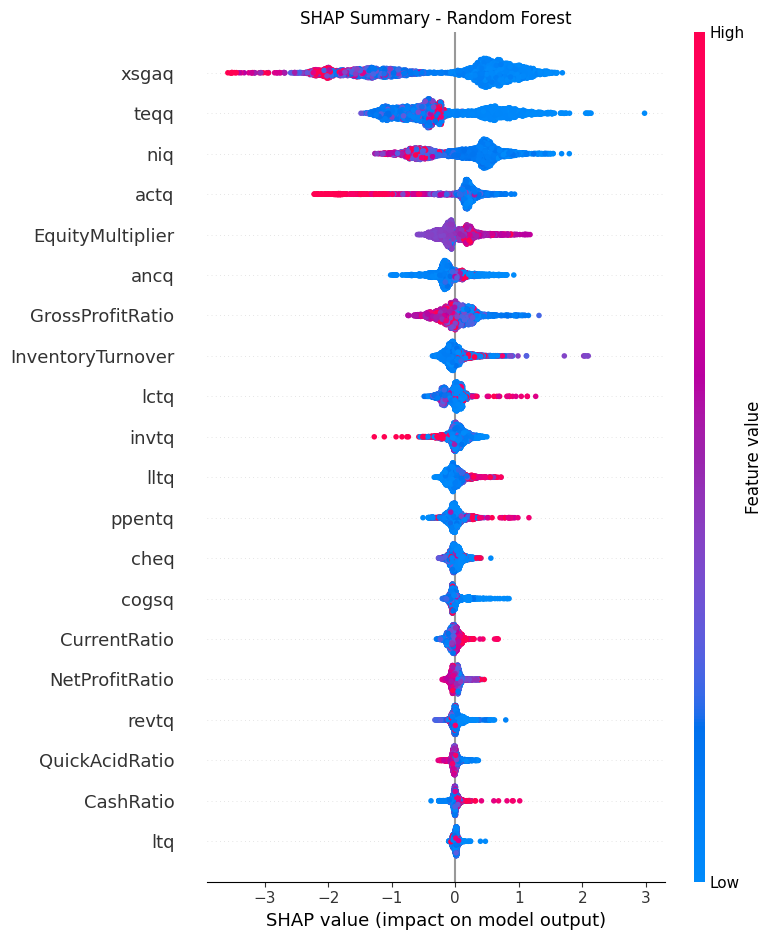

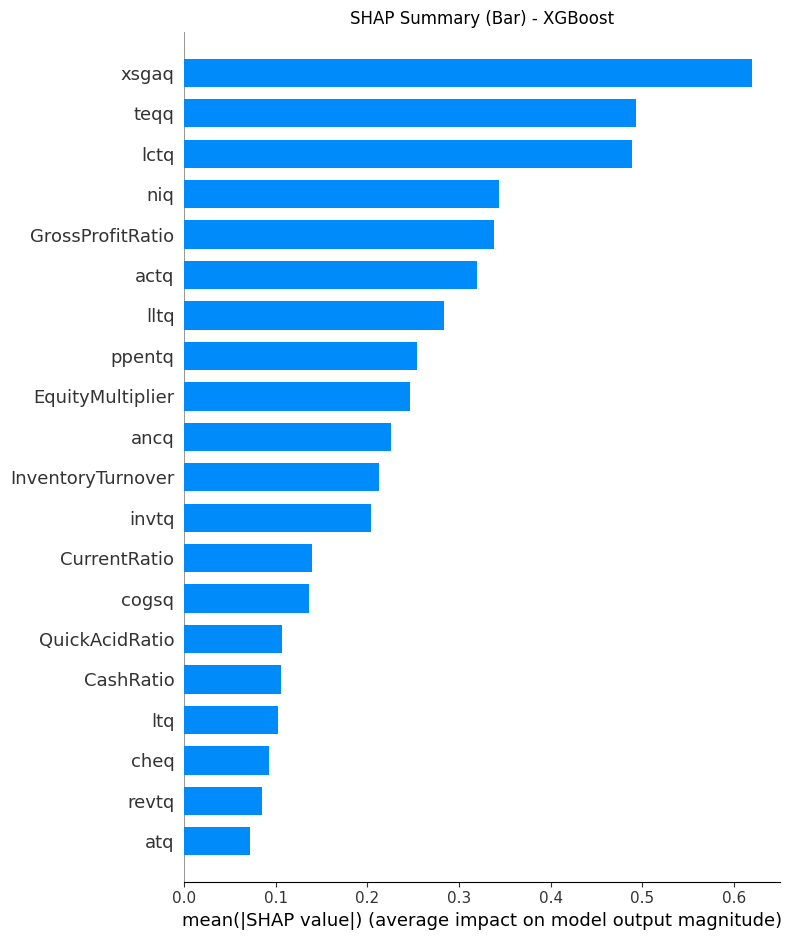

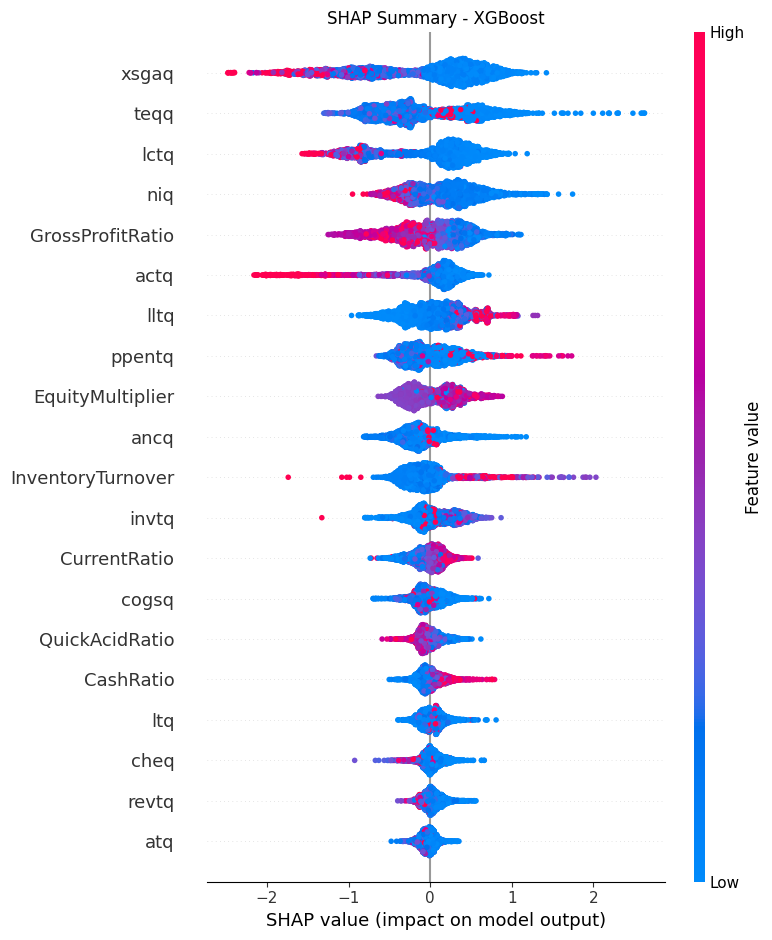

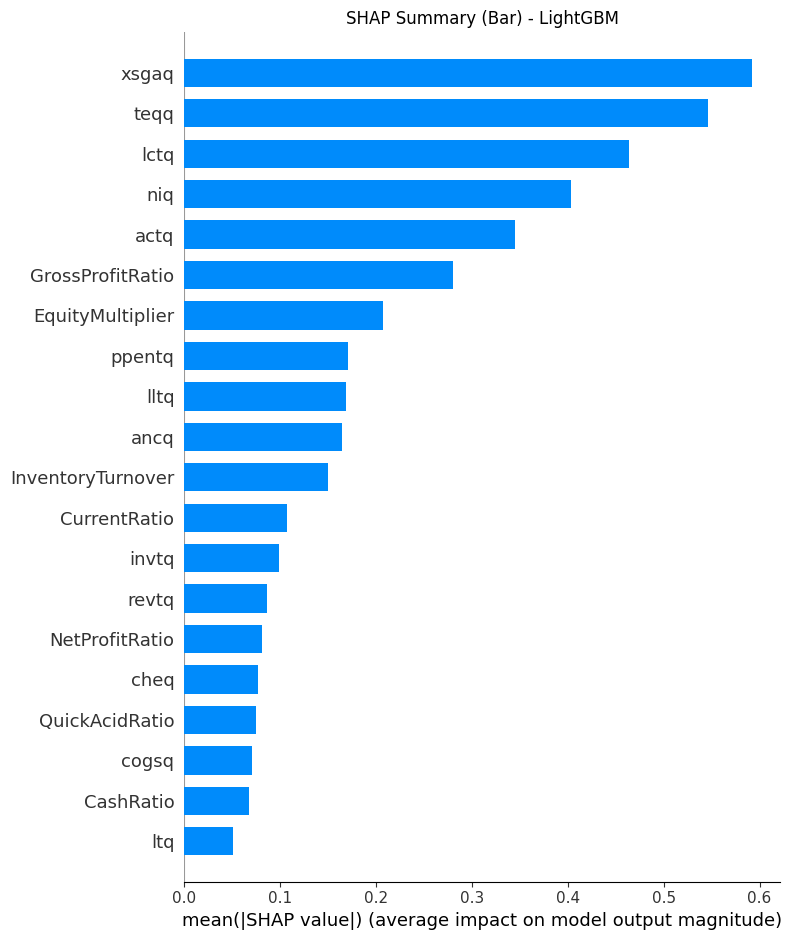

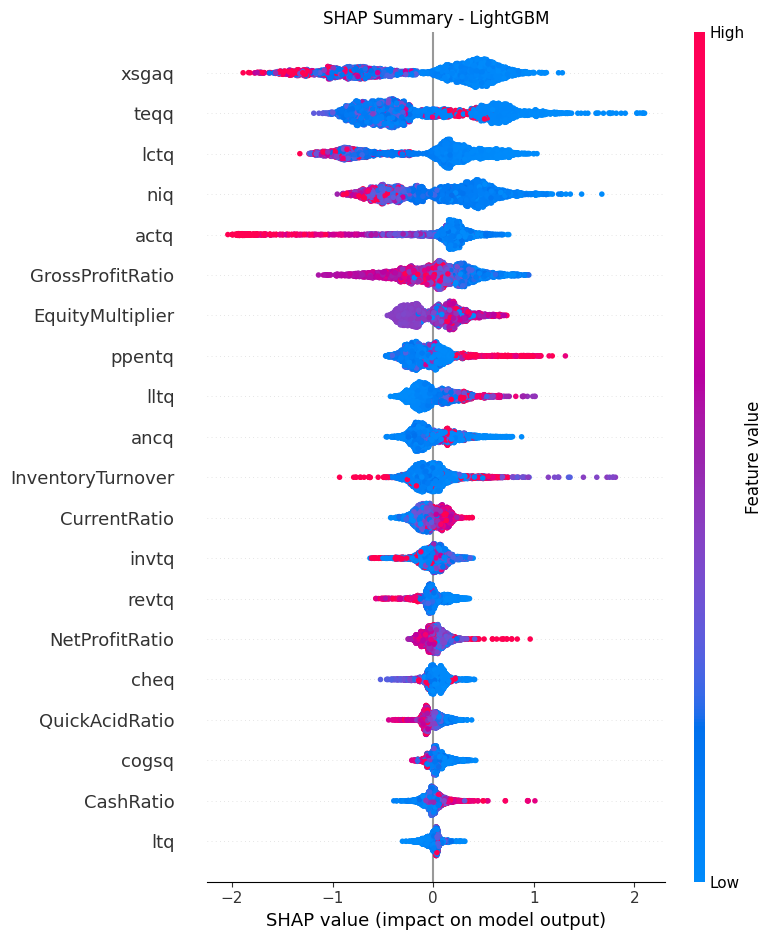

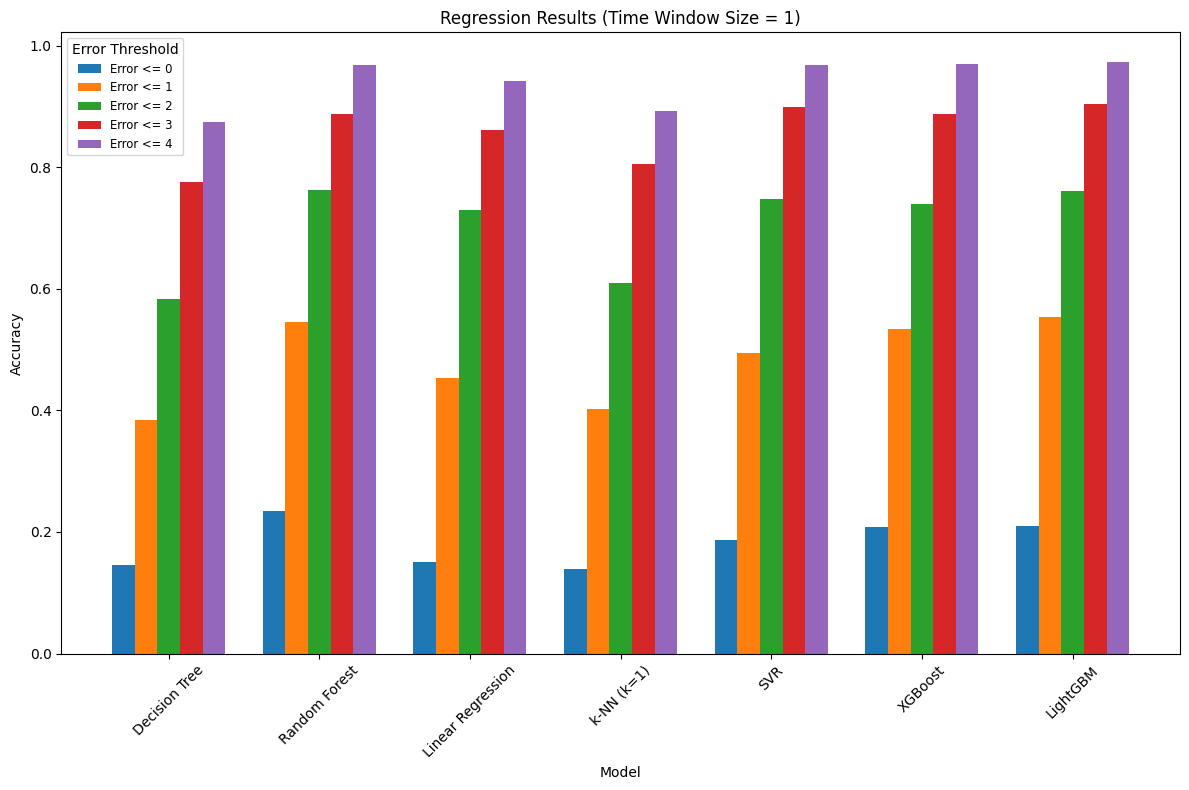

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import shap


models = {
    'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    'Linear Regression': LinearRegression(),
    'k-NN (k=1)': KNeighborsRegressor(n_neighbors=1),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1)
}

results = {'model': [], 'accuracy_0': [], 'accuracy_1': [], 'accuracy_2': [], 'accuracy_3': [], 'accuracy_4': [], 'mse': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_rounded = np.clip(y_pred_rounded, 0, 23)

    mse = mean_squared_error(y_test, y_pred)
    results['mse'].append(mse)
    
    for threshold in range(5):
        accuracy = np.mean(np.abs(y_test - y_pred_rounded) <= threshold)
        results[f'accuracy_{threshold}'].append(accuracy)

    results['model'].append(model_name)

    # SHAP analysis
    if model_name in ['XGBoost', 'LightGBM', 'Random Forest', 'Decision Tree']:
        explainer = shap.TreeExplainer(model)

        shap_values = explainer.shap_values(X_test)
        
        # Grouped SHAP summary plots
        plt.title(f"SHAP Summary (Bar) - {model_name}")
        shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=train_df.drop(columns=['company', 'period', 'rating']).columns)
        
        plt.title(f"SHAP Summary - {model_name}")
        shap.summary_plot(shap_values, X_test, feature_names=train_df.drop(columns=['company', 'period', 'rating']).columns)

results_df = pd.DataFrame(results)

plot_grouped_bar_chart(results_df, graph_title='Regression Results (Time Window Size = 1)')

In [7]:
results_df

,model,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4,mse
0,Decision Tree,0.145557,0.384831,0.583248,0.775792,0.873851,9.045710
1,Random Forest,0.233912,0.545199,0.763023,0.887130,0.968335,4.874833
2,Linear Regression,0.151430,0.453269,0.729571,0.860572,0.942288,5.714403
3,k-NN (k=1),0.139683,0.401685,0.609551,0.804903,0.891982,8.909602
4,SVR,0.186159,0.494893,0.747957,0.899387,0.967314,4.930915
5,XGBoost,0.208376,0.534474,0.739019,0.888151,0.969867,4.786061
6,LightGBM,0.209397,0.552860,0.761236,0.903728,0.973187,4.618161
